## Project Description


A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. In this project, we will develop a Reinforcement Learning (RL) agent. The trained agent makes the decision to push the cart to the left or right based on the cart position, velocity, and the pole angle, angular velocity.

### Action Space

The action is an *ndarray* with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

### State Space

We define *observation* as a state (they are used interchangeably here). The observation is an *ndarray* with shape (4,) with the values corresponding to the following positions and velocities:

| **Observation[n]** | **Observation**       | **Min**             | **Max**           |
| ------- | --------------------- | ------------------- | ----------------- |
| **0**   | Cart Position         | \-4.8               | 4.8               |
| **1**   | Cart Velocity         | \-Inf               | Inf               |
| **2**   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| **3**   | Pole Angular Velocity | \-Inf               | Inf               |

## Conditions

The challenge is to balance the pole for **500 states per episode**. 

The pole is said to be balanced if:
* Pole Angle is at most ±12°
* Cart Position is at most ±2.4 (center of the cart reaches the edge of the display)

Violation to any of the above two conditions defines an unbalanced pole.

## Solution

We have considered two options for our reinforcement learning algorithm, DQN(**Q-learning**) and PPO(**Proximal Policy Optimization**)

**DQN**
* Uses experience replay to learn from all past policies
* Freezes target Q-network to avoid the moving target issue
* Clip rewards or normalize network adaptive to sensible range

![image](https://user-images.githubusercontent.com/87069189/221127139-9876d36c-d7dc-4224-817e-9e4f6ac40a82.png)

**PPO**
* We maintain two networkes, one with the current policy that we want to refine and second that we use to collect samples
* Clip the objective and calculate the ratio between the new policy and old policy

![image](https://user-images.githubusercontent.com/87069189/221127443-c2cacde4-9e83-44cc-8ac3-ee8a1fdb3687.png)

After considering various factors, we will be using **Proximal Policy Optimization (PPO)**. 




### Rationale

* PPO is generally **more sample-efficient** than Q-learning. It can learn the optimal policy more quickly using fewer samples from the environment. This is useful for this cartpole balancing problem, where each episode is relatively short and time-consuming.

* PPO **can handle continuous state spaces**, whereas Q-learning requires discretization of the state space. Since the cartpole balancing problem has a continuous state space, this could be an advantage for PPO.

* PPO is a **policy optimization algorithm**, which means that it directly optimizes the policy rather than estimating the optimal action-value function. This can be **advantageous when the optimal policy is complex** or difficult to represent in a tabular form, as is the case in many RL problems.

## Import Dependencies

Stable Baselines is a set of improved implementations of Reinforcement Learning (RL) algorithms based on OpenAI Baselines. We will be importing the PPO algorithm from here.

* Reference & more details: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
* Implementation code of PPO in stable-baseline3: https://github.com/DLR-RM/stable-baselines3/tree/master/stable_baselines3/ppo

In [ ]:
import gym
from gym.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import torch
import glob
from IPython.display import HTML
from IPython import display as ipythondisplay
import io
import base64

## Environment Testing

In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

## Model Training

Check if CUDA device is available.

In [ ]:
torch.cuda.is_available()
print(torch.version.cuda)

11.7


## Vectorized Environment

Vectorized Environments are a method for stacking multiple independent environments into a single environment.

This provides two benefits:

* Agent experience can be collected more quickly
* The experience will contain a more diverse range of states, it usually improves exploration

Stable-Baselines provides two types of Vectorized Environment:

* SubprocVecEnv which run each environment in a separate process
* DummyVecEnv which run all environment on the same process
In practice, DummyVecEnv is usually faster than SubprocVecEnv because of communication delays that subprocesses have.

In [ ]:
env = gym.make(env_name)
env = DummyVecEnv([lambda: env])

model = PPO('MlpPolicy', env, verbose=1, device="cuda") # run this if you have an nVidia GPU installed
# model = PPO('MlpPolicy', env, verbose=1, device="auto")   # otherwise run this instead

Using cuda device


## Training the model

Begin training the model using a total timestep of 10000 (i.e., 10000 actions)

* total_timesteps – (int) The total number of samples to train on

* Note: total_timesteps is the number of steps in total the agent will do for any environment. The total_timesteps can be across several episodes, meaning that this value is not bound to some maximum

In [5]:
# total_timesteps is the number of env.steps(action) being run during training
model.learn(total_timesteps=10000, progress_bar=True)

Output()

-----------------------------
| time/              |      |
|    fps             | 346  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 334         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008590811 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.00359     |
|    learning_rate        | 0.0003      |
|    loss                 | 7.1         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0164     |
|    value_loss           | 52.7        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 335         |
|    iterations           | 3           |
|    time_elapsed         | 18          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.010366876 |
|    clip_fraction        | 0.0716      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.665      |
|    explained_variance   | 0.0771      |
|    learning_rate        | 0.0003      |
|    loss                 | 10.1        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 34.5        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 338         |
|    iterations           | 4           |
|    time_elapsed         | 24          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008022514 |
|    clip_fraction        | 0.0778      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.635      |
|    explained_variance   | 0.186       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.5        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 60.7        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 333          |
|    iterations           | 5            |
|    time_elapsed         | 30           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0073952246 |
|    clip_fraction        | 0.0621       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.61        |
|    explained_variance   | 0.203        |
|    learning_rate        | 0.0003       |
|    loss                 | 33.5         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0147      |
|    value_loss           | 71           |
------------------------------------------


## Task 1 (Model Testing)

In [6]:
observation = env.reset()
action, _ = model.predict(observation)
print("Observation space is: ", observation)
print("Action taken is: ", action)

Observation space is:  [[-0.02523366 -0.02063061  0.02495755  0.01651973]]
Action taken is:  [0]


## Task 2 (Average Score)

* We ran the trained agent for 100 episodes, and we displayed the score that the agent received for each episode

* Then, we calculated the average score of that the agent received for the 100 episodes

In [7]:
sum_episode_scores = []

for episode in range(1, 100):    ## total 10 episodes
    score = 0                   ## reward init
    obs = env.reset()         ## observations
    done = False                ## episode completes will make done True
    state = 0

    while True:
        action = model.predict(obs)[0]
        n_state, reward, done, info = env.step(action)      ## apply action 
        if (abs(n_state[0][0]) > 2.4 or abs(n_state[0][2]) > 0.209):
            break
        if state == 500:
            break
        obs = n_state
        score += reward  
        state += 1      

    print('Episode:', episode, ';   Score:', score)
    sum_episode_scores.append(score)


print("Average score is ", sum(sum_episode_scores) / len(sum_episode_scores))

env.close()

Episode: 1 ;   Score: [500.]
Episode: 2 ;   Score: [500.]
Episode: 3 ;   Score: [31.]
Episode: 4 ;   Score: [500.]
Episode: 5 ;   Score: [500.]
Episode: 6 ;   Score: [500.]
Episode: 7 ;   Score: [500.]
Episode: 8 ;   Score: [500.]
Episode: 9 ;   Score: [500.]
Episode: 10 ;   Score: [411.]
Episode: 11 ;   Score: [500.]
Episode: 12 ;   Score: [500.]
Episode: 13 ;   Score: [500.]
Episode: 14 ;   Score: [500.]
Episode: 15 ;   Score: [500.]
Episode: 16 ;   Score: [500.]
Episode: 17 ;   Score: [500.]
Episode: 18 ;   Score: [500.]
Episode: 19 ;   Score: [500.]
Episode: 20 ;   Score: [500.]
Episode: 21 ;   Score: [500.]
Episode: 22 ;   Score: [500.]
Episode: 23 ;   Score: [500.]
Episode: 24 ;   Score: [500.]
Episode: 25 ;   Score: [500.]
Episode: 26 ;   Score: [500.]
Episode: 27 ;   Score: [500.]
Episode: 28 ;   Score: [128.]
Episode: 29 ;   Score: [500.]
Episode: 30 ;   Score: [500.]
Episode: 31 ;   Score: [500.]
Episode: 32 ;   Score: [155.]
Episode: 33 ;   Score: [500.]
Episode: 34 ;   Scor

* We then plotted the score of each episode onto a graph and from the graph, we can see that our trained agent performs well on each of the 100 episodes, with only a few outliers.

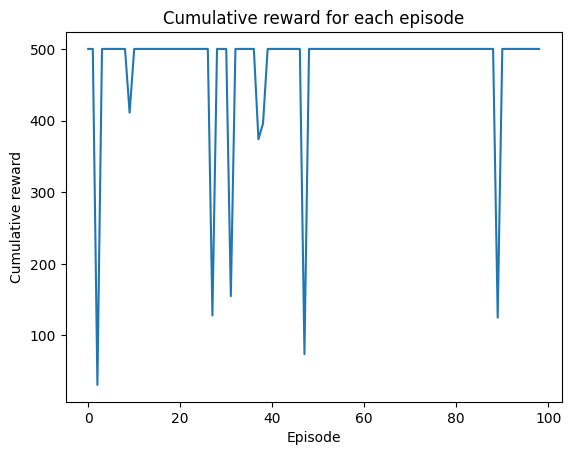

In [8]:
plt.plot(sum_episode_scores)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")
plt.show()

## Task 3 (1 Episode)

* Task 3 requires us to render one of the episodes played by our PPO agent

In [9]:
from IPython import display as ipythondisplay

def show_video():
    ipythondisplay.clear_output(wait=True)
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                     loop controls style="height: 400px;">
                     <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                     </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

In [12]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
total = 0
while True:
    state = 0
    env.render()
    action = model.predict(observation)[0]
    n_state, reward, done, info = env.step( int(action))      ## apply action 
    if (abs(n_state[0]) > 2.4 or abs(n_state[2]) > 0.209):
        break
    if state == 500:
        break
    observation = n_state 
    total += reward
    state += 1        

env.close()
show_video()

In [13]:
print("Episode reward is ", total)

Episode reward is  206.0
